In [68]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from sklearn.linear_model import RidgeCV
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 10,
                    'axes.spines.right': False,
                    'axes.spines.top':   False,
                    'legend.frameon':       False,})


# plt.rcParams.update({'font.size': 10,
#                     'axes.spines.right': False,
#                     'axes.spines.top':   False,
#                     'legend.frameon':       False,
#                     'font.sans-serif': 'Helvetica',
#                     'svg.fonttype': 'none'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from GLM_regression import *

filepath = "SSTindivsomata_GLM.mat"
# filepath = "NDNFindivsomata_GLM.mat"
# filepath = "EC_GLM.mat"

reorganized_data, variable_list = load_data(filepath)
GLM_params = fit_GLM(reorganized_data)
    

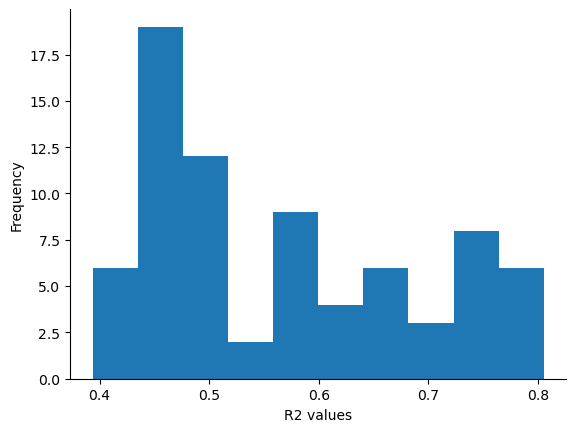

In [51]:
all_R2_values = []
for animal in GLM_params:
    for neuron in GLM_params[animal]:
        all_R2_values.append(GLM_params[animal][neuron]['R2'])
all_R2_values = np.array(all_R2_values)
plt.hist(all_R2_values.flatten(), bins=10)
plt.xlabel("R2 values")
plt.ylabel("Frequency")
plt.show()


R2: 0.8053189988819718
alpha: 1.0


/Users/ag1880/github-repos/Milstein-Lab/interneuron-glm/GLM_regression.py:155: RuntimeWarning: invalid value encountered in divide
  for neuron_nr in range(len(GLM_params[animal_key])):


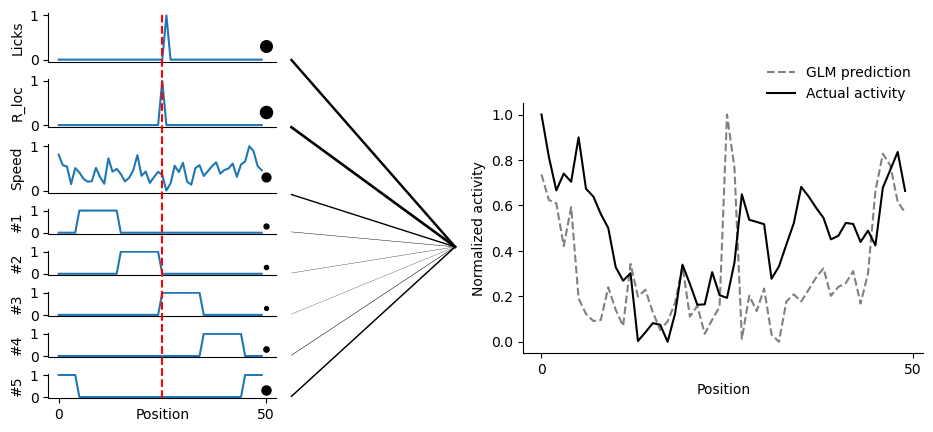

In [295]:
example_animal='animal_6'
plot_example_neuron(example_animal, reorganized_data, GLM_params, variable_list, trial=22)

<BarContainer object of 8 artists>

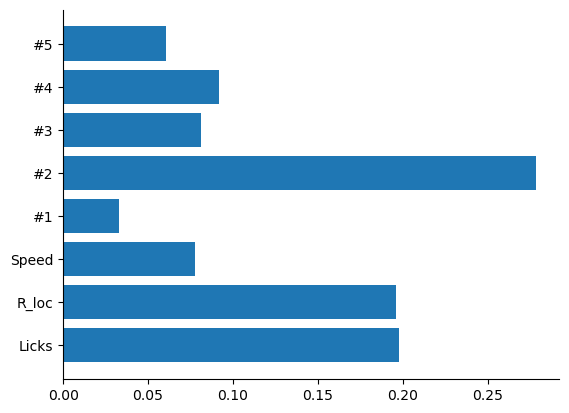

In [367]:
neuron_nr = 2

# Bar graph
plt.barh(variable_list[1:], GLM_params['animal_1'][neuron_nr]['weights'])

ValueError: x and y must be the same size

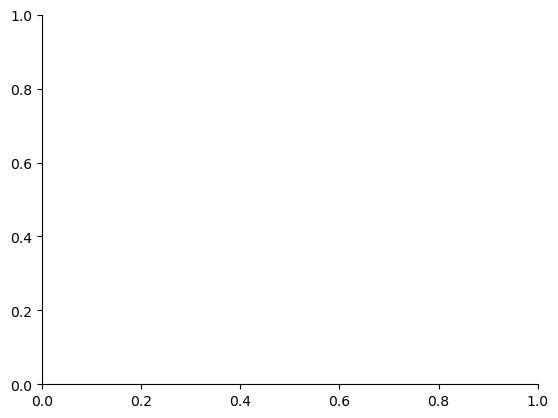

In [13]:
animal_averages = []
animal_stds = []

jitter_strength = 0.28

for animal_key in GLM_params:
    neuron_weights = []
    for neuron_nr in range(len(GLM_params[animal_key])):
        neuron_weights.append(GLM_params[animal_key][neuron_nr]['weights'])        
        jittered_x = np.arange(len(variable_list[1:])) + np.random.uniform(-jitter_strength, jitter_strength, len(variable_list[1:]))
        plt.scatter(jittered_x, GLM_params[animal_key][neuron_nr]['weights'], color='grey', alpha=0.5)
    
    neuron_weights = np.array(neuron_weights)
    mean_weights = np.mean(neuron_weights, axis=0)
    std_weights = np.std(neuron_weights, axis=0)  # Use standard deviation
    
    animal_averages.append(mean_weights)
    animal_stds.append(std_weights)    
    plt.scatter(range(len(variable_list[1:])), mean_weights, color='black', label=f'Animal {animal_key}', s=100)

animal_averages = np.array(animal_averages)
animal_stds = np.array(animal_stds)

global_mean = np.mean(animal_averages, axis=0)
global_std = np.std(animal_averages, axis=0)
plt.errorbar(range(len(variable_list[1:])), global_mean, yerr=global_std, fmt='o', color='red', ecolor='red', 
             capsize=5, label='Average of all animals', markersize=10)

plt.xticks(range(len(variable_list[1:])), variable_list[1:], rotation=45, ha='right')
plt.xlabel('Variables')
plt.ylabel('Weights')
plt.title('Neuron Weights Scatter Plot')

plt.hlines(0, 0, len(variable_list[1:]), linestyles='--', color='black', alpha=0.5)

plt.tight_layout()
plt.show()
